# Automated RandomForest based on raster and shapefile data

The following code runs an automated Random Forest classifier for pixel value based on the extraction of features from source rasters (variable to be predicted variables) and rasters for the variables you want to use to predict.

It is divided into three main sections. Each section will ask you to provide additional information for the process. Please respond according to the question. Most of them are yes/no questions (you must answer literally and in lower case) or a menu of options. In the latter case, you will be required to write the number corresponding to the option you prefer.

The following is a list of the sections and the required files to run it:

* **Extracting data** : This section loads the necessary libraries for the whole code. It also requires:
     * A source raster with the projection you will use for all the process.
     * The set of rasters you will use to create the model. They don't need to have the same projection as the source file (the code will automatically reproject them), but the extension of the source raster MUST BE WITHIN THE EXTENTION OF ALL THE OTHER RASTERS.
     * A points shapefile  (shp) with a field named 'id' that contains an integer identifier for each of the points on the raster you want to use to create the model.
     * That you choose a name for a text file to store the data for the construction of the model.
         * The output of this section is a file containing the database of extracted values for the model.

* **Random Forest** : This section constructs the model. It also requires:
    * A name for the file where the information of the model is stored.
    * That you select what is your target variable in the model (what you want to predict) and the variables you want to use to predict such a value.
    * That you choose the number of cores you want to use for running the code (we recommend you to leave at least one core out of the process, sou you can use your computer while the code is running).
    * That you choose the number of trees for the forest. If you are unsure of the number of trees, use 150, run all the code and then, use the plot of error vs number of trees to assess a proper forest size. Then, run this section again.
        * The output of this section is the Random Forest model.
* **Predicting values**: This section uses the constructed model to predict future values based on a set of predictive variables. In this case, you MUST have the rasters containing such variables stored within a folder named *futurerastes*. That folder has to be in the same directory where this code is bein runned. These rasters have to be in the same projection as your shapefile. It also requires:
    * That ALL the raster you will use to predict have THE EXACT SAME NAME as those you used to create the model in the previous section.
    * That you choose a name for a text file to store the data for the variables to predict the target values.
    * That you select how you want to call the target variable in the final database file you will use to rasterize the prediction (it can be any name you want; please avoid starting with numbers, using spaced or hyphens).
        * The output of this section is a text file with the predicted values for each point of the shapefile corresponding to a position in the raster file). It will also produce:
            * A plot of importance for each variable.
            * A plot of error vs number of trees. For this value, you must select a maximum number of trees to test. It must be higher than 16, the minimum number of trees is fixed in 15. This operation can take some time (depending on the maximum number of trees), so grab a cup of coffee after you start running it. 
    

# Extracting data

In [1]:
from datetime import datetime
import os
import urllib
import rasterio
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import time
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import time
import requests
from rasterio.plot import show
from tempfile import mkdtemp
from rasterio import Affine
from rasterio import windows
import math
import subprocess
import shutil
from osgeo import gdal, ogr
import pandas as pd
from osgeo import osr
import pyinputplus as pyput
from math import floor
import pandas as pd
import struct
from csv import DictWriter
import datetime
import math
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import multiprocessing
print('You already ran me dude!')

You already ran me dude!


In [2]:
directorio=os.getcwd()
reference=pyput.inputMenu(prompt='Please, select a reference file (I will use it to project all raster to its CRS)\n', choices=[file for file in os.listdir() if '.tif' in file], numbered=True)
print('You already ran me dude!')

Please, select a reference file (I will use it to project all raster to its CRS)
1. bosque.tif
2. hidrcarb.tif
3. idp.tif
4. lulc.tif
5. mineria.tif
6. palma.tif
7. pastos.tif
8. precip.tif
9. tmp.tif
10. ttravel.tif
4
You already ran me dude!


In [6]:
d = gdal.Open(reference)
proj = osr.SpatialReference(wkt=d.GetProjection())
projcode_ref=proj.GetAttrValue('AUTHORITY',1)
#if todos!='yes':
alguno=pyput.inputYesNo(prompt='Do you wish to reproject any map')
todos='no'
if alguno=='no':
    pass
else:
    todos=pyput.inputYesNo(prompt=f'Should I reproject all tif files in {directorio}? (yes/no)')
if todos=='yes':
    convertir=set([file for file in os.listdir() if '.tif' in file and '.aux' not in file])-{reference}
    for archivo in convertir:
        d = gdal.Open(archivo)
        proj = osr.SpatialReference(wkt=d.GetProjection())
        projcode_target=proj.GetAttrValue('AUTHORITY',1)
        if projcode_ref != projcode_target:
            archivoentrada=archivo
            archivosalida='proj_'+archivo
            resize=f'gdalwarp -s_srs EPSG:{projcode_target} -t_srs EPSG:{projcode_ref} -dstnodata -9999.0 -r near -of GTiff {archivoentrada} {archivosalida}'
            subprocess.call(resize, shell=True)
            os.remove(archivo)
elif alguno=='yes':
    target=pyput.inputMenu(prompt='Please, select a target file (I will use it to project all raster to its CRS)\n', choices=list(set([file for file in os.listdir() if '.tif' in file])-{reference}), numbered=True)
    d = gdal.Open(target)
    proj = osr.SpatialReference(wkt=d.GetProjection())
    projcode_target=proj.GetAttrValue('AUTHORITY',1)
    archivoentrada=target
    archivosalida='proj_'+target
    resize=f'gdalwarp -s_srs EPSG:{projcode_target} -t_srs EPSG:{projcode_ref} -dstnodata -9999.0 -r near -of GTiff {archivoentrada} {archivosalida}'
    subprocess.call(resize, shell=True)
    os.remove(target)
else:
    pass
    
print('You already ran me dude!')

Do you wish to reproject any mapno
You already ran me dude!


In [7]:
features = [file for file in os.listdir() if '.tif' in file and '.aux' not in file]
columnames=[nombre.split('.')[0] for nombre in features]
columnames.insert(0, 'id')
archivodb=pyput.inputFilename(prompt='Please, give me a file name to store the data (is must finish in .txt or .csv)')
pd.DataFrame(columns=columnames).to_csv(archivodb, index=False)

def getrastervalue(rasters_list, feat, dbfile):
    valores={}
    feat_id = feat.GetField('id')
    paravalores=list()
    for feature in rasters_list:
        src_ds=gdal.Open(feature) 
        gt=src_ds.GetGeoTransform()
        rb=src_ds.GetRasterBand(1)
        geom = feat.GetGeometryRef()
        mx, my = geom.GetX(), geom.GetY()
        px = int((mx - gt[0]) / gt[1])
        py = int((my - gt[3]) / gt[5])
        intval = rb.ReadAsArray(px, py, 1, 1)
        paravalores.append(intval[0][0])
        valores[feat_id]=paravalores
    df=pd.DataFrame.from_dict(valores, orient='index')
    f = open(dbfile, 'a')
    df.to_csv(f, header=False)
    f.close()
    #return(valores)
archivopuntos=pyput.inputFilename(prompt='Please, write the name of the points shapefile (it must end with .shp and have the same crs that the target)')
hocico=ogr.Open(archivopuntos)
lyr=hocico.GetLayer()


for feat in lyr:
    feat_id = feat.GetField('id')
    getrastervalue(features, feat, archivodb)


print('You already ran me dude!')

Please, give me a file name to store the data (is must finish in .txt or .csv)datatest.txt
Please, write the name of the points shapefile (it must end with .shp and have the same crs that the target)ptest.shp
You already ran me dude!


# Random Forest

In [14]:
dbfile=pyput.inputFilename(prompt='Please write the name of the file containing the training data for the model')
df=pd.read_csv(dbfile)
variables=list(df.columns)
variables.remove('id')
Xvar=[]
Yvar=pyput.inputMenu(prompt='Please select a target variable (what you want to predict)\n', choices=variables, numbered=True)
variables.remove(Yvar)
anadirvar='yes'
while anadirvar=='yes':
    if len(Xvar)==0:
        print('You have not chosen explanatory variables for the model')
    else:
        print('Explanatory variables for the model are:')
        print(Xvar)
    addvariable=pyput.inputMenu(prompt='Please select a new variable to add\n', choices=variables, numbered=True, blank=True)
    Xvar.append(addvariable)
    variables.remove(addvariable)
    anadirvar=pyput.inputYesNo(prompt='Do you want to add another variable?')
print('You already ran me dude!')

Please write the name of the file containing the training data for the modeldatatest.txt
Please select a target variable (what you want to predict)
1. bosque
2. hidrcarb
3. idp
4. lulc
5. mineria
6. palma
7. pastos
8. precip
9. tmp
10. ttravel
4
You have not chosen explanatory variables for the model
Please select a new variable to add
1. bosque
2. hidrcarb
3. idp
4. mineria
5. palma
6. pastos
7. precip
8. tmp
9. ttravel
1
Do you want to add another variable?yes
Explanatory variables for the model are:
['bosque']
Please select a new variable to add
1. hidrcarb
2. idp
3. mineria
4. palma
5. pastos
6. precip
7. tmp
8. ttravel
1
Do you want to add another variable?yes
Explanatory variables for the model are:
['bosque', 'hidrcarb']
Please select a new variable to add
1. idp
2. mineria
3. palma
4. pastos
5. precip
6. tmp
7. ttravel
1
Do you want to add another variable?yes
Explanatory variables for the model are:
['bosque', 'hidrcarb', 'idp']
Please select a new variable to add
1. mineria
2

In [15]:
X_train= df.iloc[:math.floor(df.shape[0]*0.75)][Xvar]#select explanatory columns from df
y_train=df.iloc[:math.floor(df.shape[0]*0.75)][Yvar]#select target variable from df
X_test= df.iloc[math.floor(df.shape[0]*0.75):][Xvar]#select explanatory columns from df
y_test=df.iloc[math.floor(df.shape[0]*0.75):][Yvar]#select target variable from df
print('You already ran me dude!')

You already ran me dude!


In [16]:
nucleos=multiprocessing.cpu_count()

In [17]:
forestsize=pyput.inputInt(prompt='Please, write the number of trees you want to use in the forest')
coresnumber=pyput.inputInt(prompt=f'Please, write the number of cores you want to use for the processing of the model (you have {nucleos} available, I recommend you to use {nucleos-1})')
print('If you do not know how many trees you should use for the forest, please run all the code and check the error vs number of trees plot, then run this section again.')

Please, write the number of trees you want to use in the forest150
Please, write the number of cores you want to use for the processing of the model (you have 4 available, I recommend you to use 3)3
If you do not know how many trees you should use for the forest, please run all the code and check the error vs number of trees plot, then run this section again.


In [48]:
clf = RandomForestClassifier(random_state=125, n_estimators=forestsize, oob_score=True)
clf.fit(X_train, y_train)
print('You already ran me dude!')

You already ran me dude!


In [49]:
print(clf.score(X_train, y_train))
print('This is the score of correct prediction from the training set')

1.0
This is the score of correct prediction from the training set


In [50]:
print(clf.score(X_test, y_test))
print('This is the score of correct prediction from the test set')


0.6428571428571429
This is the score of correct prediction from the test set


# Predicting future values

In [51]:
features = [os.path.join('futurerasters',file) for file in os.listdir('futurerasters') if '.tif' in file and '.aux' not in file]
columnames=[nombre.split('.')[0] for nombre in features]
columnames.insert(0, 'id')

archivodb=pyput.inputFilename(prompt='Please, give me a file name to store the data for 2050 (is must finish in .txt or .csv)')

pd.DataFrame(columns=columnames).to_csv(archivodb, index=False)

def getrastervalue(rasters_list, feat, dbfile):
    valores={}
    feat_id = feat.GetField('id')
    paravalores=list()
    for feature in rasters_list:
        src_ds=gdal.Open(feature) 
        gt=src_ds.GetGeoTransform()
        rb=src_ds.GetRasterBand(1)
        geom = feat.GetGeometryRef()
        mx, my = geom.GetX(), geom.GetY()
        px = int((mx - gt[0]) / gt[1])
        py = int((my - gt[3]) / gt[5])
        intval = rb.ReadAsArray(px, py, 1, 1)
        paravalores.append(intval[0][0])
        valores[feat_id]=paravalores
    df=pd.DataFrame.from_dict(valores, orient='index')
    f = open(dbfile, 'a')
    df.to_csv(f, header=False)
    f.close()
    #return(valores)
archivopuntos=pyput.inputFilename(prompt='Please, write the name of the points shapefile (it must en with .shp and have the same crs that the target)')
hocico=ogr.Open(archivopuntos)
lyr=hocico.GetLayer()

#t1=datetime.datetime.now()
for feat in lyr:
    feat_id = feat.GetField('id')
    getrastervalue(features, feat, archivodb)
print('You already ran me dude!')

Please, give me a file name to store the data for 2050 (is must finish in .txt or .csv)datatest50.txt
Please, write the name of the points shapefile (it must en with .shp and have the same crs that the target)ptest.shp
You already ran me dude!


In [ ]:
'''reference=pyput.inputMenu(prompt='Please, select a reference file (I will use it to project all raster to its CRS)\n', choices=[file for file in os.listdir() if '.tif' in file], numbered=True)
d = gdal.Open(reference)
proj = osr.SpatialReference(wkt=d.GetProjection())
projcode_ref=proj.GetAttrValue('AUTHORITY',1)
convertir=set([file for file in os.listdir('futurerasters') if '.tif' in file and '.aux' not in file])-{reference}
for archivo in convertir:
    archivo=os.path.join('futurerasters',archivo)
    d = gdal.Open(archivo)
    proj = osr.SpatialReference(wkt=d.GetProjection())
    projcode_target=proj.GetAttrValue('AUTHORITY',1)
    if projcode_ref != projcode_target:
        archivoentrada=archivo
        archivosalida='proj_'+archivo
        resize=f'gdalwarp -s_srs EPSG:{projcode_target} -t_srs EPSG:{projcode_ref} -dstnodata -9999.0 -r near -of GTiff {archivoentrada} {archivosalida}'
        subprocess.call(resize, shell=True)
        os.remove(archivo)'''

In [52]:
df1=pd.read_csv(archivodb)
print('You already ran me dude!')

You already ran me dude!


In [53]:
columnames1=[os.path.split(columna)[-1] if columna!='id' else columna for columna in df1.columns]
df1.columns=columnames1
df1
print('You already ran me dude!')

You already ran me dude!


In [54]:
df2=df1.drop(['id'], axis=1)
print('You already ran me dude!')

You already ran me dude!


In [55]:
X_pred=clf.predict(df2)
print('You already ran me dude!')

You already ran me dude!


In [56]:
df3=pd.DataFrame(df1['id'])
print('You already ran me dude!')

You already ran me dude!


In [57]:
predictedvar=pyput.inputFilename(prompt='Please, write the name of predicted variable (please, start with a letter and do not include spaces or hyphens)\n')
df3[predictedvar]=X_pred
print('You already ran me dude!')

Please, write the name of predicted variable (please, start with a letter and do not include spaces or hyphens)
n3
You already ran me dude!


In [58]:
archivopredicted=pyput.inputFilename(prompt='Please, write the name of the file to store the predictions (is must finish in .txt or .csv)')
df3.to_csv(archivopredicted, index=False)
print('You already ran me dude!')

Please, write the name of the file to store the predictions (is must finish in .txt or .csv)lulc50t.txt
You already ran me dude!


In [59]:
y=clf.feature_importances_

In [60]:
x=df2.columns

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

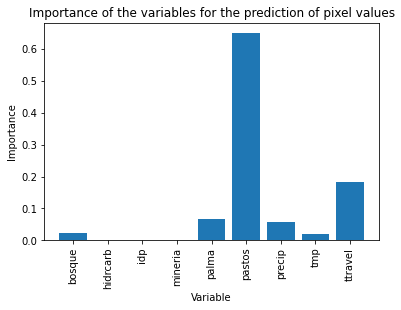

In [61]:
plt.bar(x,y)
plt.title('Importance of the variables for the prediction of pixel values')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.xticks(rotation=90)

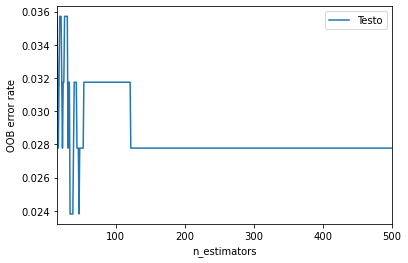

0:04:06.298578


In [65]:
t1=datetime.datetime.now()
min_estimators = 15
max_estimators = 500
error_rate={'Testo':[]}
label='Testo'
for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i, n_jobs=-2)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()
t2=datetime.datetime.now()
print(t2-t1)

In [ ]:
''''silenciame''''